In [1]:
%matplotlib inline
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import numpy as np
from oceans.ocfis import uv2spdir, spdir2uv
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

In [2]:
def get_ticks(bounds, dirs, otherbounds):
    dirs = dirs.lower()
    l0 = np.float(bounds[0])
    l1 = np.float(bounds[1])
    r = np.max([l1 - l0, np.float(otherbounds[1]) - np.float(otherbounds[0])])
    if r <= 1.5:
        # <1.5 degrees: 15' major ticks, 5' minor ticks
        minor_int = 1.0 / 12.0
        major_int = 1.0 / 4.0
    elif r <= 3.0:
        # <3 degrees: 30' major ticks, 10' minor ticks
        minor_int = 1.0 / 6.0
        major_int = 0.5
    elif r <= 7.0:
        # <7 degrees: 1d major ticks, 15' minor ticks
        minor_int = 0.25
        major_int = np.float(1)
    elif r <= 15:
        # <15 degrees: 2d major ticks, 30' minor ticks
        minor_int = 0.5
        major_int = np.float(2)
    elif r <= 30:
        # <30 degrees: 3d major ticks, 1d minor ticks
        minor_int = np.float(1)
        major_int = np.float(3)
    else:
        # >=30 degrees: 5d major ticks, 1d minor ticks
        minor_int = np.float(1)
        major_int = np.float(5)

    minor_ticks = np.arange(np.ceil(l0 / minor_int) * minor_int, np.ceil(l1 / minor_int) * minor_int + minor_int,
                            minor_int)
    minor_ticks = minor_ticks[minor_ticks <= l1]
    major_ticks = np.arange(np.ceil(l0 / major_int) * major_int, np.ceil(l1 / major_int) * major_int + major_int,
                            major_int)
    major_ticks = major_ticks[major_ticks <= l1]

    if major_int < 1:
        d, m, s = dd2dms(np.array(major_ticks))
        if dirs == 'we' or dirs == 'ew' or dirs == 'lon' or dirs == 'long' or dirs == 'longitude':
            n = 'W' * sum(d < 0)
            p = 'E' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" + dir[i] for i in
                                 range(len(d))]
        elif dirs == 'sn' or dirs == 'ns' or dirs == 'lat' or dirs == 'latitude':
            n = 'S' * sum(d < 0)
            p = 'N' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" + dir[i] for i in
                                 range(len(d))]
        else:
            major_tick_labels = [str(int(d[i])) + u"\N{DEGREE SIGN}" + str(int(m[i])) + "'" for i in range(len(d))]
    else:
        d = major_ticks
        if dirs == 'we' or dirs == 'ew' or dirs == 'lon' or dirs == 'long' or dirs == 'longitude':
            n = 'W' * sum(d < 0)
            p = 'E' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + dir[i] for i in range(len(d))]
        elif dirs == 'sn' or dirs == 'ns' or dirs == 'lat' or dirs == 'latitude':
            n = 'S' * sum(d < 0)
            p = 'N' * sum(d >= 0)
            dir = n + p
            major_tick_labels = [str(np.abs(int(d[i]))) + u"\N{DEGREE SIGN}" + dir[i] for i in range(len(d))]
        else:
            major_tick_labels = [str(int(d[i])) + u"\N{DEGREE SIGN}" for i in range(len(d))]

    return minor_ticks, major_ticks, major_tick_labels

In [3]:
def add_map_features(ax, extent):
#     # Gridlines and grid labels
#     gl = ax.gridlines(
#         draw_labels=True,
#         linewidth=.5,
#         color='black',
#         alpha=0.25,
#         linestyle='--',
#     )

#     gl.xlabels_top = gl.ylabels_right = False
#     gl.xlabel_style = {'size': 16, 'color': 'black'}
#     gl.ylabel_style = {'size': 16, 'color': 'black'}

#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER

    xl = [extent[0], extent[1]]
    yl = [extent[2], extent[3]]

    tick0x, tick1, ticklab = get_ticks(xl, 'we', yl)
    ax.set_xticks(tick0x, minor=True, crs=ccrs.PlateCarree())
    ax.set_xticks(tick1, crs=ccrs.PlateCarree())
    ax.set_xticklabels(ticklab, fontsize=14)

    # get and add latitude ticks/labels
    tick0y, tick1, ticklab = get_ticks(yl, 'sn', xl)
    ax.set_yticks(tick0y, minor=True, crs=ccrs.PlateCarree())
    ax.set_yticks(tick1, crs=ccrs.PlateCarree())
    ax.set_yticklabels(ticklab, fontsize=14)

    gl = ax.gridlines(draw_labels=False, linewidth=.5, color='gray', alpha=0.75, linestyle='--', crs=ccrs.PlateCarree())
    gl.xlocator = mticker.FixedLocator(tick0x)
    gl.ylocator = mticker.FixedLocator(tick0y)

    ax.tick_params(which='major',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   length=5, width=2)

    ax.tick_params(which='minor',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   width=1)

    # Axes properties and features
    ax.set_extent(extent)
    ax.add_feature(LAND, zorder=0, edgecolor='black')
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(state_lines, edgecolor='black')
    return ax

In [4]:
import xarray as xr
# file = '/Users/mikesmith/Downloads/5MHz_6km_realtime-agg_2f30_fcd6_a21e.nc'
file = '/Users/Fishp/Downloads/decadal_means.nc'

ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                    (lat: 185, lon: 155)
Coordinates:
  * lon                        (lon) float32 -76.97678 -76.9187 ... -68.0332
  * lat                        (lat) float32 33.54882 33.60276 ... 43.47378
Data variables:
    u_mean                     (lat, lon) float32 ...
    v_mean                     (lat, lon) float32 ...
    winter_u_mean              (lat, lon) float32 ...
    winter_v_mean              (lat, lon) float32 ...
    winter_u_within_year_var   (lat, lon) float32 ...
    winter_v_within_year_var   (lat, lon) float32 ...
    winter_within_year_rms     (lat, lon) float32 ...
    winter_u_between_year_var  (lat, lon) float32 ...
    winter_v_between_year_var  (lat, lon) float32 ...
    winter_between_year_rms    (lat, lon) float32 ...
    spring_u_mean              (lat, lon) float32 ...
    spring_v_mean              (lat, lon) float32 ...
    spring_u_within_year_var   (lat, lon) float32 ...
    spring_v_within_year_var   (lat, lon) float32 ...
    spring_within_year_rms     (lat, lon) float32 ...
    spring_u_between_year_var  (lat, lon) float32 ...
    spring_v_between_year_var  (lat, lon) float32 ...
    spring_between_year_rms    (lat, lon) float32 ...
    summer_u_mean              (lat, lon) float32 ...
    summer_v_mean              (lat, lon) float32 ...
    summer_u_within_year_var   (lat, lon) float32 ...
    summer_v_within_year_var   (lat, lon) float32 ...
    summer_within_year_rms     (lat, lon) float32 ...
    summer_u_between_year_var  (lat, lon) float32 ...
    summer_v_between_year_var  (lat, lon) float32 ...
    summer_between_year_rms    (lat, lon) float32 ...
    fall_u_mean                (lat, lon) float32 ...
    fall_v_mean                (lat, lon) float32 ...
    fall_u_within_year_var     (lat, lon) float32 ...
    fall_v_within_year_var     (lat, lon) float32 ...
    fall_within_year_rms       (lat, lon) float32 ...
    fall_u_between_year_var    (lat, lon) float32 ...
    fall_v_between_year_var    (lat, lon) float32 ...
    fall_between_year_rms      (lat, lon) float32 ...
    u_within_year_var          (lat, lon) float32 ...
    v_within_year_var          (lat, lon) float32 ...
    within_year_rms            (lat, lon) float32 ...
    u_mean_annual              (lat, lon) float32 ...
    v_mean_annual              (lat, lon) float32 ...
    u_between_year_var         (lat, lon) float32 ...
    v_between_year_var         (lat, lon) float32 ...
    between_year_rms           (lat, lon) float32 ...

In [5]:
lon = ds['lon']
lat = ds['lat']

In [6]:
projection = ccrs.PlateCarree()

extent = [
    lon.min(),
    lon.max(),
    lat.min(),
    lat.max()
]

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='face',
    facecolor='tan'
)

state_lines = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

In [7]:
tds = ds.coarsen(lon=2, lat=2, boundary='pad').mean()
tds

<xarray.Dataset>
Dimensions:                    (lat: 93, lon: 78)
Coordinates:
  * lon                        (lon) float32 -76.94774 -76.83159 ... -68.0332
  * lat                        (lat) float32 33.57579 33.68367 ... 43.47378
Data variables:
    u_mean                     (lat, lon) float32 nan nan nan ... nan nan nan
    v_mean                     (lat, lon) float32 nan nan nan ... nan nan nan
    winter_u_mean              (lat, lon) float32 nan nan nan ... nan nan nan
    winter_v_mean              (lat, lon) float32 nan nan nan ... nan nan nan
    winter_u_within_year_var   (lat, lon) float32 nan nan nan ... nan nan nan
    winter_v_within_year_var   (lat, lon) float32 nan nan nan ... nan nan nan
    winter_within_year_rms     (lat, lon) float32 nan nan nan ... nan nan nan
    winter_u_between_year_var  (lat, lon) float32 nan nan nan ... nan nan nan
    winter_v_between_year_var  (lat, lon) float32 nan nan nan ... nan nan nan
    winter_between_year_rms    (lat, lon) float32 nan nan nan ... nan nan nan
    spring_u_mean              (lat, lon) float32 nan nan nan ... nan nan nan
    spring_v_mean              (lat, lon) float32 nan nan nan ... nan nan nan
    spring_u_within_year_var   (lat, lon) float32 nan nan nan ... nan nan nan
    spring_v_within_year_var   (lat, lon) float32 nan nan nan ... nan nan nan
    spring_within_year_rms     (lat, lon) float32 nan nan nan ... nan nan nan
    spring_u_between_year_var  (lat, lon) float32 nan nan nan ... nan nan nan
    spring_v_between_year_var  (lat, lon) float32 nan nan nan ... nan nan nan
    spring_between_year_rms    (lat, lon) float32 nan nan nan ... nan nan nan
    summer_u_mean              (lat, lon) float32 nan nan nan ... nan nan nan
    summer_v_mean              (lat, lon) float32 nan nan nan ... nan nan nan
    summer_u_within_year_var   (lat, lon) float32 nan nan nan ... nan nan nan
    summer_v_within_year_var   (lat, lon) float32 nan nan nan ... nan nan nan
    summer_within_year_rms     (lat, lon) float32 nan nan nan ... nan nan nan
    summer_u_between_year_var  (lat, lon) float32 nan nan nan ... nan nan nan
    summer_v_between_year_var  (lat, lon) float32 nan nan nan ... nan nan nan
    summer_between_year_rms    (lat, lon) float32 nan nan nan ... nan nan nan
    fall_u_mean                (lat, lon) float32 nan nan nan ... nan nan nan
    fall_v_mean                (lat, lon) float32 nan nan nan ... nan nan nan
    fall_u_within_year_var     (lat, lon) float32 nan nan nan ... nan nan nan
    fall_v_within_year_var     (lat, lon) float32 nan nan nan ... nan nan nan
    fall_within_year_rms       (lat, lon) float32 nan nan nan ... nan nan nan
    fall_u_between_year_var    (lat, lon) float32 nan nan nan ... nan nan nan
    fall_v_between_year_var    (lat, lon) float32 nan nan nan ... nan nan nan
    fall_between_year_rms      (lat, lon) float32 nan nan nan ... nan nan nan
    u_within_year_var          (lat, lon) float32 nan nan nan ... nan nan nan
    v_within_year_var          (lat, lon) float32 nan nan nan ... nan nan nan
    within_year_rms            (lat, lon) float32 nan nan nan ... nan nan nan
    u_mean_annual              (lat, lon) float32 nan nan nan ... nan nan nan
    v_mean_annual              (lat, lon) float32 nan nan nan ... nan nan nan
    u_between_year_var         (lat, lon) float32 nan nan nan ... nan nan nan
    v_between_year_var         (lat, lon) float32 nan nan nan ... nan nan nan
    between_year_rms           (lat, lon) float32 nan nan nan ... nan nan nan

In [8]:
anglew, speedw = uv2spdir(tds.winter_u_mean, tds.winter_v_mean)  # convert u/v to angle and speed
u, v = spdir2uv(  # convert angle and speed back to u/v, normalizing the arrow sizes
    np.ones_like(speedw),
    anglew,
    deg=True
)

C:\Users\Fishp\anaconda3\envs\Thesis\lib\site-packages\oceans\ocfis.py:90: RuntimeWarning: invalid value encountered in remainder
  ang = np.mod(90.0 - ang, 360.0)  # Zero is North.


In [9]:
velocity_min = np.int32(np.nanmin(speedw)) # Get the minimum speed from the data
velocity_max =np.int32(np.nanmax(speedw)) # Get the maximum speed from the data

# velocity_min = 0 # Get the minimum speed from the data
# velocity_max = 40 # Get the maximum speed from the data

# Setup a keyword argument, kwargs, dictionary to pass optional arguments to the quiver plot
kwargs = dict(
    transform=projection,
    scale=65, # Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer. Default is None.
    headwidth=2.75, # Head width as multiple of shaft width.
    headlength=2.75, #Head length as multiple of shaft width.
    headaxislength=2.5, # Head length at shaft intersection.
    minshaft=1,
    minlength=1
)

# Clip the colors 
color_clipped = np.clip(speedw, velocity_min, velocity_max).squeeze(),

# Set the colorbar ticks to correspond to the velocity minimum and maximum of the data with a step of 20... Append the max velocity 
ticks = np.append(np.arange(velocity_min, velocity_max, 5), velocity_max)

C:\Users\Fishp\anaconda3\envs\Thesis\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Fishp\anaconda3\envs\Thesis\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after re

Text(0.5, 1.0, 'MARACOOS Average Winter Surface Currents\n from 2006 to 2017')

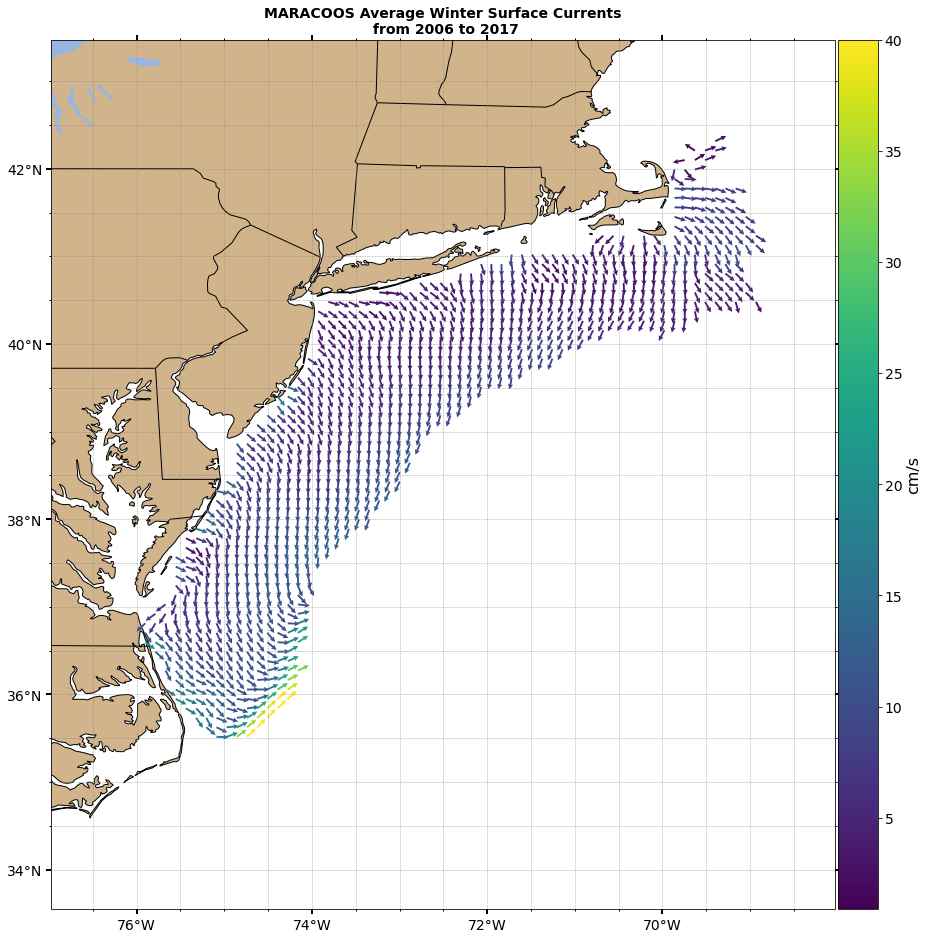

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=projection)
)

# plot arrows over pcolor
h = ax.quiver(
    tds['lon'], 
    tds['lat'], 
    u, 
    v,
    color_clipped,
    **kwargs #Pass in the kwargs from the above cell
)

# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Winter Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')


In [13]:
anglespr, speedspr = uv2spdir(tds.spring_u_mean, tds.spring_v_mean)  # convert u/v to angle and speed
u_spr, v_spr = spdir2uv(  # convert angle and speed back to u/v, normalizing the arrow sizes
    np.ones_like(speedspr),
    anglespr,
    deg=True
)

In [14]:
velocity_min = np.int32(np.nanmin(speedspr)) # Get the minimum speed from the data
velocity_max =np.int32(np.nanmax(speedspr)) # Get the maximum speed from the data

# velocity_min = 0 # Get the minimum speed from the data
velocity_max = 40 # Get the maximum speed from the data

# Setup a keyword argument, kwargs, dictionary to pass optional arguments to the quiver plot
kwargs = dict(
    transform=projection,
    scale=65, # Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer. Default is None.
    headwidth=2.75, # Head width as multiple of shaft width.
    headlength=2.75, #Head length as multiple of shaft width.
    headaxislength=2.5, # Head length at shaft intersection.
    minshaft=1,
    minlength=1
)

# Clip the colors 
color_clipped = np.clip(speedspr, velocity_min, velocity_max).squeeze(),

# Set the colorbar ticks to correspond to the velocity minimum and maximum of the data with a step of 20... Append the max velocity 
ticks = np.append(np.arange(velocity_min, velocity_max, 5), velocity_max)

<ipython-input-3-751877cfc1cc>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l0 = np.float(bounds[0])
<ipython-input-3-751877cfc1cc>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l1 = np.float(bounds[1])
<ipython-input-3-751877cfc1cc>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this wa

Text(0.5, 1.0, 'MARACOOS Average Spring Surface Currents\n from 2006 to 2017')

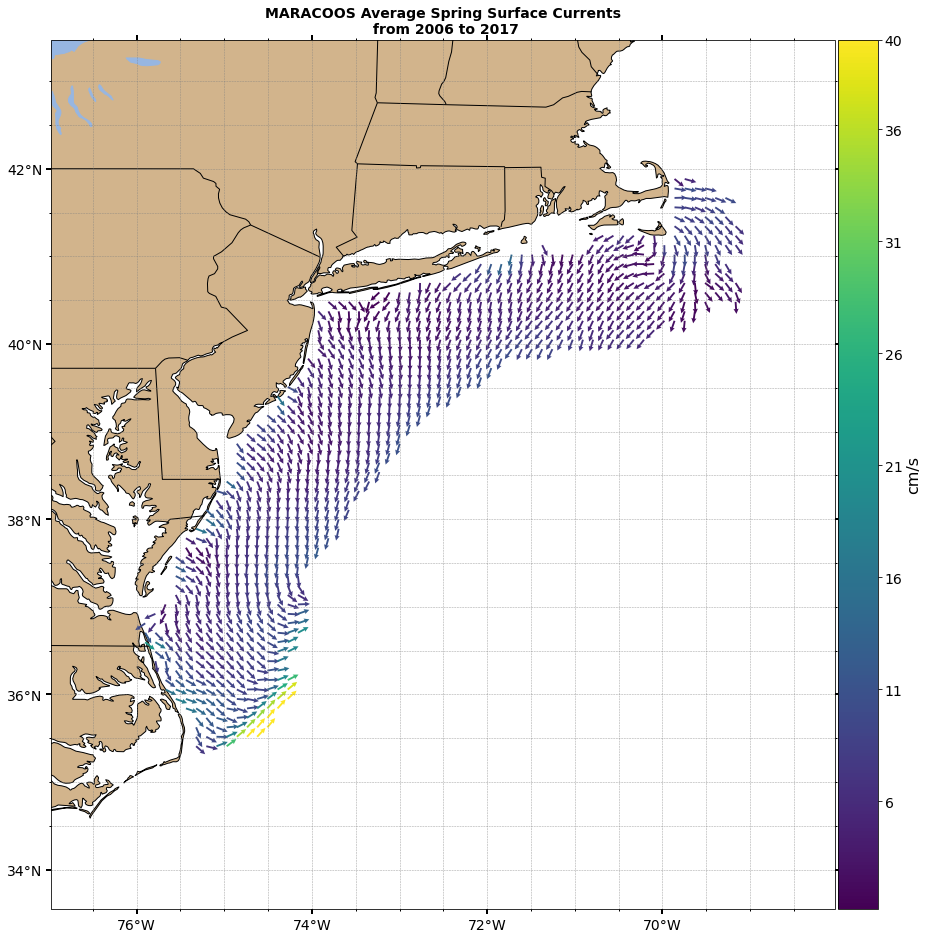

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=projection)
)

# plot arrows over pcolor
h = ax.quiver(
    tds['lon'], 
    tds['lat'], 
    u_spr, 
    v_spr,
    color_clipped,
    **kwargs #Pass in the kwargs from the above cell
)

# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Spring Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')


In [16]:
anglesum, speedsum = uv2spdir(tds.summer_u_mean, tds.summer_v_mean)  # convert u/v to angle and speed
u_sum, v_sum = spdir2uv(  # convert angle and speed back to u/v, normalizing the arrow sizes
    np.ones_like(speedsum),
    anglesum,
    deg=True
)

In [17]:
velocity_min = np.int32(np.nanmin(speedspr)) # Get the minimum speed from the data
velocity_max =np.int32(np.nanmax(speedspr)) # Get the maximum speed from the data

# velocity_min = 0 # Get the minimum speed from the data
velocity_max = 40 # Get the maximum speed from the data

# Setup a keyword argument, kwargs, dictionary to pass optional arguments to the quiver plot
kwargs = dict(
    transform=projection,
    scale=65, # Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer. Default is None.
    headwidth=2.75, # Head width as multiple of shaft width.
    headlength=2.75, #Head length as multiple of shaft width.
    headaxislength=2.5, # Head length at shaft intersection.
    minshaft=1,
    minlength=1
)

# Clip the colors 
color_clipped = np.clip(speedspr, velocity_min, velocity_max).squeeze(),

# Set the colorbar ticks to correspond to the velocity minimum and maximum of the data with a step of 20... Append the max velocity 
ticks = np.append(np.arange(velocity_min, velocity_max, 5), velocity_max)

<ipython-input-3-751877cfc1cc>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l0 = np.float(bounds[0])
<ipython-input-3-751877cfc1cc>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l1 = np.float(bounds[1])
<ipython-input-3-751877cfc1cc>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this wa

Text(0.5, 1.0, 'MARACOOS Average Summer Surface Currents\n from 2006 to 2017')

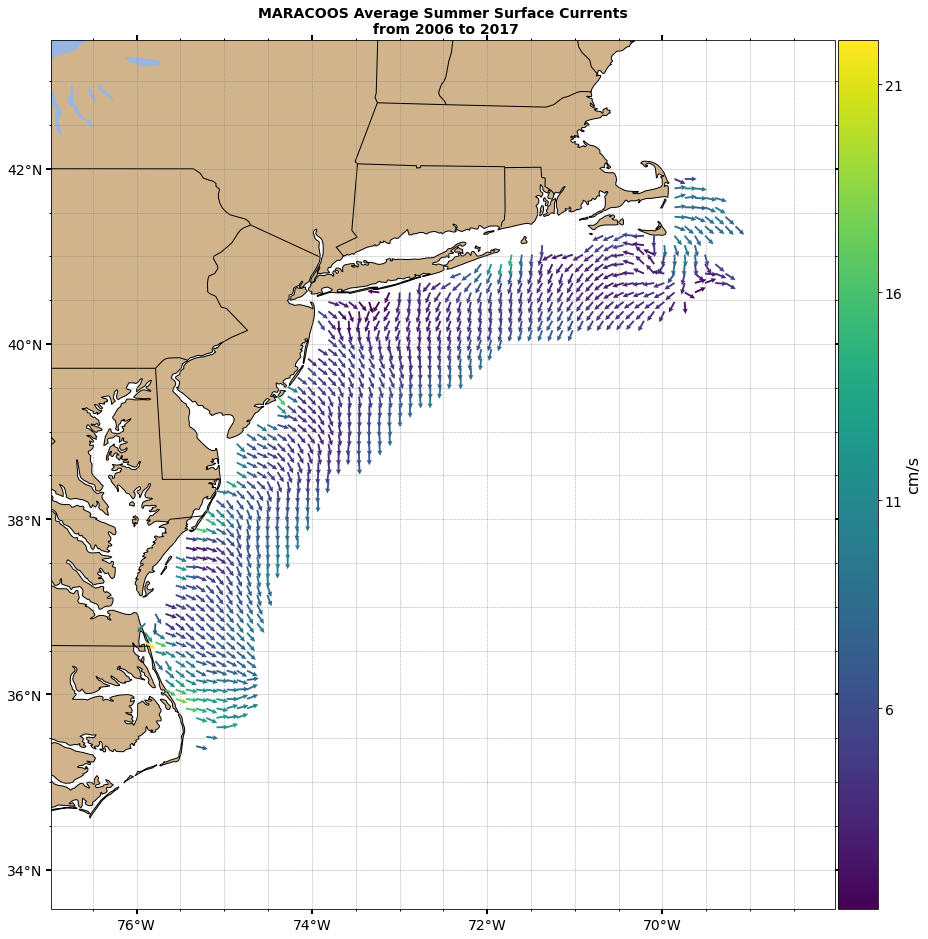

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=projection)
)

# plot arrows over pcolor
h = ax.quiver(
    tds['lon'], 
    tds['lat'], 
    u_sum, 
    v_sum,
    color_clipped,
    **kwargs #Pass in the kwargs from the above cell
)

# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Summer Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')


In [19]:
anglefall, speedfall = uv2spdir(tds.fall_u_mean, tds.fall_v_mean)  # convert u/v to angle and speed
u_fall, v_fall = spdir2uv(  # convert angle and speed back to u/v, normalizing the arrow sizes
    np.ones_like(speedfall),
    anglefall,
    deg=True
)

In [20]:
velocity_min = np.int32(np.nanmin(speedspr)) # Get the minimum speed from the data
velocity_max =np.int32(np.nanmax(speedspr)) # Get the maximum speed from the data

# velocity_min = 0 # Get the minimum speed from the data
velocity_max = 30 # Get the maximum speed from the data

# Setup a keyword argument, kwargs, dictionary to pass optional arguments to the quiver plot
kwargs = dict(
    transform=projection,
    scale=65, # Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer. Default is None.
    headwidth=2.75, # Head width as multiple of shaft width.
    headlength=2.75, #Head length as multiple of shaft width.
    headaxislength=2.5, # Head length at shaft intersection.
    minshaft=1,
    minlength=1
)

# Clip the colors 
color_clipped = np.clip(speedspr, velocity_min, velocity_max).squeeze(),

# Set the colorbar ticks to correspond to the velocity minimum and maximum of the data with a step of 20... Append the max velocity 
ticks = np.append(np.arange(velocity_min, velocity_max, 5), velocity_max)

<ipython-input-3-751877cfc1cc>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l0 = np.float(bounds[0])
<ipython-input-3-751877cfc1cc>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l1 = np.float(bounds[1])
<ipython-input-3-751877cfc1cc>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this wa

Text(0.5, 1.0, 'MARACOOS Average Fall Surface Currents\n from 2006 to 2017')

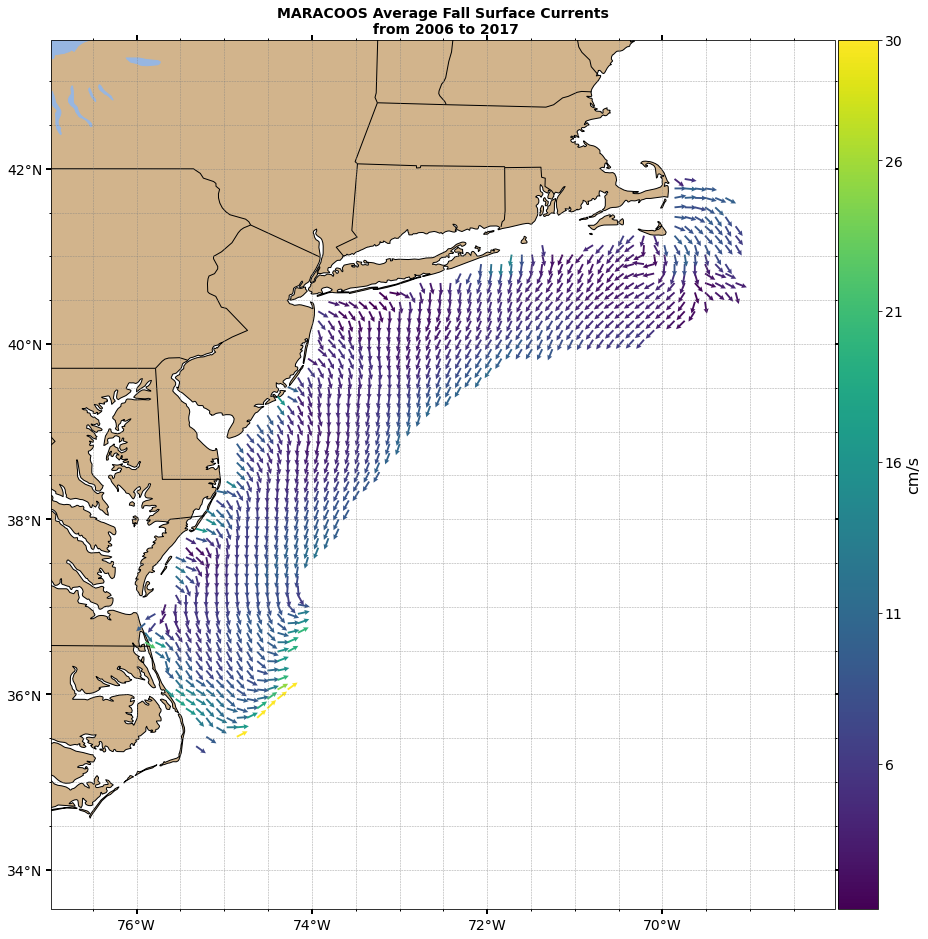

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=projection)
)

# plot arrows over pcolor
h = ax.quiver(
    tds['lon'], 
    tds['lat'], 
    u_fall, 
    v_fall,
    color_clipped,
    **kwargs #Pass in the kwargs from the above cell
)

# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Fall Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')


In [22]:
!pip install pyproj

In [22]:
import metpy.calc as mc

In [23]:
import datetime as dt
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# import functions.common as cf
# import functions.plotting as pf
import metpy.calc as mc
plt.rcParams.update({'font.size': 12})  # all font sizes are 12 unless otherwise specified


def plot_divergence(ds_sub, save_dir, interval_name, t0=None, sb_t0str=None, sb_t1str=None):
    t0 = t0 or None
    sb_t0str = sb_t0str or None
    sb_t1str = sb_t1str or None
    heights = [250, 200, 160, 10]

    plt_regions = cf.plot_regions(interval_name)
    plt_vars = dict(divergence=dict(color_label='Divergence x $10^{-4}$ (1/s)',
                                    title='Divergence',
                                    cmap=plt.get_cmap('RdBu_r')))

    la_polygon, pa_polygon = cf.extract_lease_area_outlines()

    for height in heights:
        if height == 10:
            u = ds_sub['U10']
            v = ds_sub['V10']
        else:
            u = ds_sub.sel(height=height)['U']
            v = ds_sub.sel(height=height)['V']

        hours = np.arange(1, 24)

        for hour in hours:
            u_hour = u[u.time.dt.hour == hour]
            v_hour = v[v.time.dt.hour == hour]

            # calculate hourly average
            uhm = u_hour.mean('time')
            vhm = v_hour.mean('time')

            # standardize the vectors so they only represent direction
            u_hourly_mean_standardize = uhm / cf.wind_uv_to_spd(uhm, vhm)
            v_hourly_mean_standardize = vhm / cf.wind_uv_to_spd(uhm, vhm)

            div = mc.divergence(uhm, vhm)
            plt_vars['divergence']['data'] = div * 10**4  # surface divergence, *10^-4 1/s

            for pv, plt_info in plt_vars.items():
                for pr, region_info in plt_regions.items():
                    region_savedir = os.path.join(save_dir, pr)
                    os.makedirs(region_savedir, exist_ok=True)

                    sname = '{}_{}m_{}_H{}'.format(pr, height, interval_name, str(hour).zfill(3))
                    if interval_name == 'divergence_seabreeze_days_hourly_avg':
                        ttl = 'Sea Breeze Days\nHourly Averaged {} {}m: H{}\n{} to {}'.format(plt_info['title'], height,
                                                                                              str(hour).zfill(3),
                                                                                              sb_t0str, sb_t1str)
                    elif interval_name == 'divergence_nonseabreeze_days_hourly_avg':
                        ttl = 'Non-Sea Breeze Days\nHourly Averaged {} {}m: H{}\n{} to {}'.format(plt_info['title'], height,
                                                                                              str(hour).zfill(3),
                                                                                              sb_t0str, sb_t1str)
                    else:
                        ttl = 'Sea Breeze Days\n{} {}m: H{}\n{}'.format(plt_info['title'], height, str(hour).zfill(3),
                                                                        sb_t0str)
                    sfile = os.path.join(region_savedir, sname)

                    # set up the map
                    lccproj = ccrs.LambertConformal(central_longitude=-74.5, central_latitude=38.8)
                    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=lccproj))
                    pf.add_map_features(ax, region_info['extent'], region_info['xticks'], region_info['yticks'])
                    quiver_color = 'k'

                    data = plt_info['data']

                    # subset grid
                    if region_info['subset']:
                        extent = np.add(region_info['extent'], [-.5, .5, -.5, .5]).tolist()
                        data = cf.subset_grid(data, extent)
                        u_hourly_mean_standardize = cf.subset_grid(u_hourly_mean_standardize, extent)
                        v_hourly_mean_standardize = cf.subset_grid(v_hourly_mean_standardize, extent)

                    # add lease areas
                    if region_info['lease_area']:
                        pf.add_lease_area_polygon(ax, la_polygon, '#737373')  # lease areas
                        pf.add_lease_area_polygon(ax, pa_polygon, '#969696')  # planning areas
                        #leasing_areas.plot(ax=ax, lw=.8, color='magenta', transform=ccrs.LambertConformal())

                    lon = data.XLONG.values
                    lat = data.XLAT.values

                    # initialize keyword arguments for plotting
                    kwargs = dict()

                    # plot data
                    if interval_name in ['divergence_seabreeze_days_hourly_avg', 'divergence_nonseabreeze_days_hourly_avg']:
                        kwargs['levels'] = [-2.5, -2.25, -2, -1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0.25, 0.5,
                                            0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]
                        kwargs['cbar_ticks'] = [-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]
                    else:
                        kwargs['levels'] = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5,
                                            3, 3.5, 4, 4.5, 5]
                        kwargs['cbar_ticks'] = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
                    kwargs['extend'] = 'both'

                    kwargs['ttl'] = ttl
                    kwargs['clab'] = plt_info['color_label']
                    kwargs['shift_subplot_right'] = 0.85
                    pf.plot_contourf(fig, ax, lon, lat, data, plt_info['cmap'], **kwargs)

                    # subset the quivers and add as a layer
                    if region_info['quiver_subset']:
                        quiver_scale = region_info['quiver_scale']
                        qs = region_info['quiver_subset']['_{}m'.format(height)]
                        ax.quiver(lon[::qs, ::qs], lat[::qs, ::qs], u_hourly_mean_standardize.values[::qs, ::qs],
                                  v_hourly_mean_standardize.values[::qs, ::qs], scale=quiver_scale,
                                  color=quiver_color, transform=ccrs.PlateCarree())
                    else:
                        ax.quiver(lon, lat, u_hourly_mean_standardize.values, v_hourly_mean_standardize.values,
                                  scale=quiver_scale, color=quiver_color, transform=ccrs.PlateCarree())

                    plt.savefig(sfile, dpi=200)
                    plt.close()


def main(sDir, sdate, edate, intvl):
    wrf = 'http://tds.marine.rutgers.edu/thredds/dodsC/cool/ruwrf/wrf_4_1_3km_processed/WRF_4.1_3km_Processed_Dataset_Best'

    savedir = os.path.join(sDir, '{}_{}-{}'.format(intvl, sdate.strftime('%Y%m%d'), edate.strftime('%Y%m%d')))
    os.makedirs(savedir, exist_ok=True)

    ds = xr.open_dataset(wrf)
    ds = ds.sel(time=slice(sdate, edate))
    dst0 = pd.to_datetime(ds.time.values[0]).strftime('%Y-%m-%d')
    dst1 = pd.to_datetime(ds.time.values[-1]).strftime('%Y-%m-%d')

    # define arguments for plotting function
    kwargs = dict()
    kwargs['sb_t0str'] = dst0
    kwargs['sb_t1str'] = dst1

    if intvl == 'divergence_seabreeze_days_hourly_avg':
        df = pd.read_csv(os.path.join(sDir, 'radar_seabreezes_2020.csv'))
        df = df[df['Seabreeze'] == 'y']
        sb_dates = np.array(pd.to_datetime(df['Date']))
        sb_datetimes = [pd.date_range(pd.to_datetime(x), pd.to_datetime(x) + dt.timedelta(hours=23), freq='H') for x in sb_dates]
        sb_datetimes = pd.to_datetime(sorted([inner for outer in sb_datetimes for inner in outer]))

        # grab the WRF data for the seabreeze dates
        ds = ds.sel(time=sb_datetimes)
        # ds = ds.sel(time=slice(dt.datetime(2020, 6, 1, 0, 0), dt.datetime(2020, 6, 1, 5, 0)))  # for debugging
        plot_divergence(ds, savedir, intvl, **kwargs)

    elif intvl == 'divergence_nonseabreeze_days_hourly_avg':
        df = pd.read_csv(os.path.join(sDir, 'radar_seabreezes_2020.csv'))
        df = df[df['Seabreeze'] == 'y']
        sb_dates = np.array(pd.to_datetime(df['Date']))
        sb_datetimes = [pd.date_range(pd.to_datetime(x), pd.to_datetime(x) + dt.timedelta(hours=23), freq='H') for x in sb_dates]
        sb_datetimes = pd.to_datetime(sorted([inner for outer in sb_datetimes for inner in outer]))

        # grab the WRF data for the non-seabreeze dates
        nosb_datetimes = [t for t in ds.time.values if t not in sb_datetimes]
        ds_nosb = ds.sel(time=nosb_datetimes)
        # ds_nosb = ds.sel(time=slice(dt.datetime(2020, 6, 2, 0, 0), dt.datetime(2020, 6, 2, 5, 0)))  # for debugging
        plot_divergence(ds_nosb, savedir, intvl, **kwargs)

    else:
        plot_divergence(ds, savedir, intvl, **kwargs)


# if __name__ == '__main__':
#     # save_directory = '/Users/garzio/Documents/rucool/bpu/wrf/windspeed_averages'
#     save_directory = '/www/home/lgarzio/public_html/bpu/windspeed_averages'  # on server
#     start_date = dt.datetime(2020, 6, 1, 0, 0)  # dt.datetime(2019, 9, 1, 0, 0)
#     end_date = dt.datetime(2020, 7, 31, 23, 0)  # dt.datetime(2020, 9, 1, 0, 0)
#     interval = 'divergence_nonseabreeze_days_hourly_avg'  # divergence_seabreeze_days_hourly_avg divergence_nonseabreeze_days_hourly_avg  divergence_hourly - use this for daily intervals
#     main(save_directory, start_date, end_date, interval)

In [24]:
import cmocean as cmo

In [25]:
import pyproj

In [24]:
# !pip uninstall pyproj

In [26]:
pyproj.datadir.get_data_dir()

'C:\\Users\\Fishp\\anaconda3\\envs\\swbc2021\\lib\\site-packages\\pyproj\\proj_dir\\share\\proj'

In [27]:
tds

<xarray.Dataset>
Dimensions:                    (lat: 93, lon: 78)
Coordinates:
  * lon                        (lon) float32 -76.95 -76.83 ... -68.12 -68.03
  * lat                        (lat) float32 33.58 33.68 33.79 ... 43.39 43.47
Data variables: (12/42)
    u_mean                     (lat, lon) float32 nan nan nan ... nan nan nan
    v_mean                     (lat, lon) float32 nan nan nan ... nan nan nan
    winter_u_mean              (lat, lon) float32 nan nan nan ... nan nan nan
    winter_v_mean              (lat, lon) float32 nan nan nan ... nan nan nan
    winter_u_within_year_var   (lat, lon) float32 nan nan nan ... nan nan nan
    winter_v_within_year_var   (lat, lon) float32 nan nan nan ... nan nan nan
    ...                         ...
    within_year_rms            (lat, lon) float32 nan nan nan ... nan nan nan
    u_mean_annual              (lat, lon) float32 nan nan nan ... nan nan nan
    v_mean_annual              (lat, lon) float32 nan nan nan ... nan nan nan
    u_between_year_var         (lat, lon) float32 nan nan nan ... nan nan nan
    v_between_year_var         (lat, lon) float32 nan nan nan ... nan nan nan
    between_year_rms           (lat, lon) float32 nan nan nan ... nan nan nan

In [28]:
div = mc.divergence(tds['u_mean'], tds['v_mean'])
div.plot(cmap=cmo.cm.balance)

CRSError: Invalid datum string: urn:ogc:def:datum:EPSG::6326: (Internal Proj Error: proj_create: SQLite error on SELECT name, ellipsoid_auth_name, ellipsoid_code, prime_meridian_auth_name, prime_meridian_code, area_of_use_auth_name, area_of_use_code, deprecated FROM geodetic_datum WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

In [ ]:
div = mc.divergence(tds['u_mean'], tds['v_mean'])
div.plot(cmap=cmo.cm.balance)

In [ ]:
import metpy.calc as mc

In [29]:
velocity_min = np.int32(np.nanmin(speedw)) # Get the minimum speed from the data
velocity_max =np.int32(np.nanmax(speedw)) # Get the maximum speed from the data

# velocity_min = 0 # Get the minimum speed from the data
velocity_max = 40 # Get the maximum speed from the data

# Setup a keyword argument, kwargs, dictionary to pass optional arguments to the quiver plot
kwargs = dict(
    transform=projection,
    scale=65, # Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer. Default is None.
    headwidth=2.75, # Head width as multiple of shaft width.
    headlength=2.75, #Head length as multiple of shaft width.
    headaxislength=2.5, # Head length at shaft intersection.
    minshaft=1,
    minlength=1,
    zorder=1000
)

# Clip the colors 
color_clipped = np.clip(speedw, velocity_min, velocity_max).squeeze(),

# Set the colorbar ticks to correspond to the velocity minimum and maximum of the data with a step of 20... Append the max velocity 
ticks = np.append(np.arange(velocity_min, velocity_max, 5), velocity_max)

<ipython-input-2-751877cfc1cc>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l0 = np.float(bounds[0])
<ipython-input-2-751877cfc1cc>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l1 = np.float(bounds[1])
<ipython-input-2-751877cfc1cc>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this wa

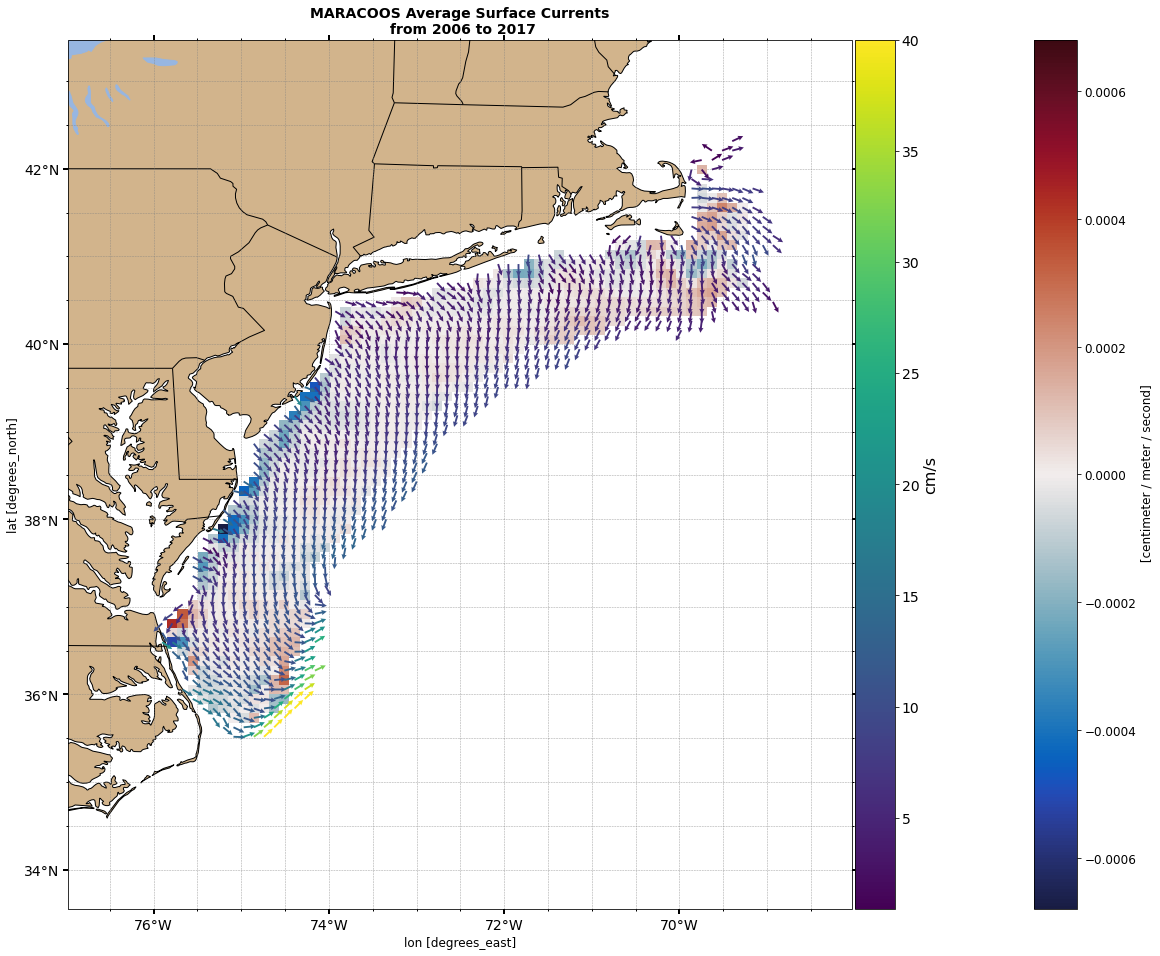

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=projection)
)

# plot arrows over pcolor
h = ax.quiver(
    tds['lon'], 
    tds['lat'], 
    u, 
    v,
    color_clipped,
    **kwargs #Pass in the kwargs from the above cell
)
div.plot(cmap=cmo.cm.balance,zorder=10)
# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')
plt.savefig('Divergence 10 year mean')
plt.show()


<ipython-input-2-751877cfc1cc>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l0 = np.float(bounds[0])
<ipython-input-2-751877cfc1cc>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l1 = np.float(bounds[1])
<ipython-input-2-751877cfc1cc>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this wa

ValueError: The Axes must have been created in the present figure

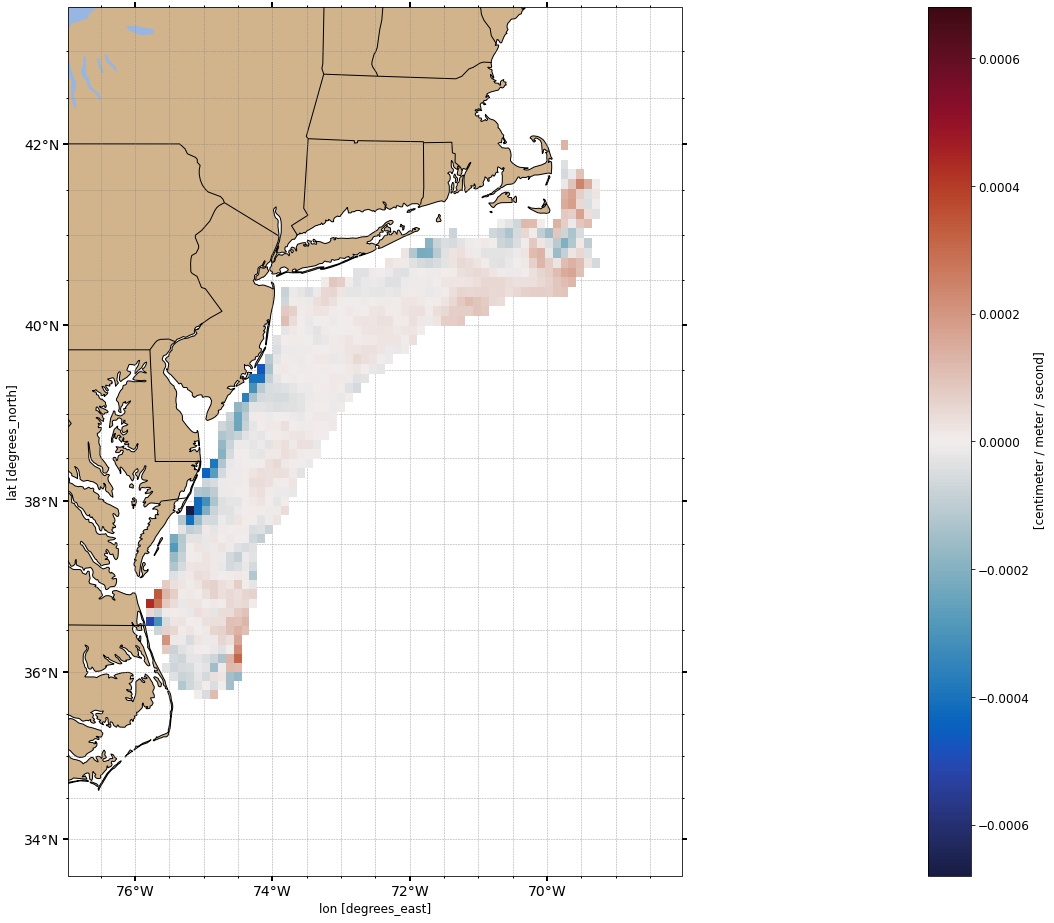

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=ccrs.Mercator())
)

# plot arrows over pcolor
# h = ax.quiver(
#     tds['lon'], 
#     tds['lat'], 
#     u, 
#     v,
#     color_clipped,
#     **kwargs #Pass in the kwargs from the above cell
# )
div.plot(cmap=cmo.cm.balance,zorder=10,transform=ccrs.PlateCarree())
# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
# cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')
plt.savefig('Divergence 10 year mean')
plt.show()


NameError: name 'cm' is not defined

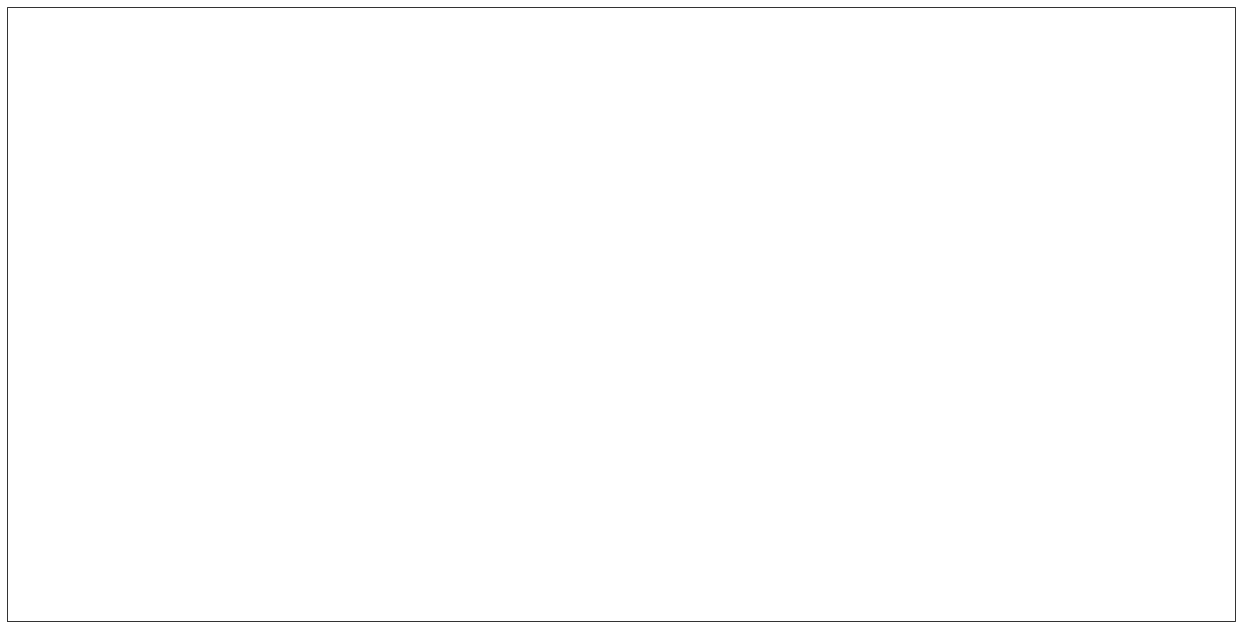

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=projection)
)

# plot arrows over pcolor
# h = ax.quiver(
#     tds['lon'], 
#     tds['lat'], 
#     u, 
#     v,
#     color_clipped,
#     **kwargs #Pass in the kwargs from the above cell
# )
div.plot(cmap=cm.cmo.balance,zorder=10)
# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')
# plt.savefig('Divergence 10 year mean')
plt.show()


In [ ]:
divwinter = mc.divergence(tds['winter_u_mean'], tds['winter_v_mean'])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=projection)
)

# plot arrows over pcolor
h = ax.quiver(
    tds['lon'], 
    tds['lat'], 
    u, 
    v,
    color_clipped,
    **kwargs #Pass in the kwargs from the above cell
)
divwinter.plot(cmap=cmo.cm.balance,zorder=10)
# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Winter Divergence Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')


In [ ]:
divspring = mc.divergence(tds['spring_u_mean'], tds['spring_v_mean'])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Initialize blank plot with a mercator projection
fig, ax = plt.subplots(
    figsize=(22, 16),
    subplot_kw=dict(projection=projection)
)

# plot arrows over pcolor
h = ax.quiver(
    tds['lon'], 
    tds['lat'], 
    u_spr, 
    v_spr,
    color_clipped,
    **kwargs #Pass in the kwargs from the above cell
)
divspring.plot(cmap=cmo.cm.balance,zorder=10)
# Add map features to the axes
add_map_features(ax, extent)

# Create a space for the colorbar to the right of the plot
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

# Create the colorbar in the space above
cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks], fontsize=14)
cb.set_label('cm/s', fontsize=16)
# t0_str = pd.Timestamp(time_start).strftime('%Y-%m-%d %H:%M:00')
# t1_str = pd.Timestamp(time_end).strftime('%Y-%m-%d %H:%M:00')
ax.set_title(f'MARACOOS Average Winter Divergence Surface Currents\n from 2006 to 2017', fontsize=14, fontweight='bold')


In [ ]:
divsummer = mc.divergence(tds['summer_u_mean'], tds['summer_v_mean'])

In [ ]:
divfall = mc.divergence(tds['fall_u_mean'], tds['fall_v_mean'])